#**CIS 419/519**


## Natural Language Processing (NLP)  

In this worksheet, we will learn-
1. How to use word2vec
2. Train a 1D CNN, RNN and LSTM model for binary classification problem



---
# Setup

In [ ]:
# imports

!pip install gensim==3.8
!pip install torchtext==0.4.0
!pip install unidecode
!pip install d2l

import re
import os
import sys
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from gensim.models import Word2Vec
from nltk.corpus import brown
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors

from IPython.display import Image, YouTubeVideo
from torch.nn import functional as F
from d2l import torch as d2l

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 24.2 MB 54 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 53 kB 1.3 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0
     |████████████████████████████████| 235 kB 5.3 MB/s 
     |████████████████████████████████| 83 kB 1.3 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Unzipping

In [ ]:
# @title Seeds
seed = 522
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/"
              "course-content/master/nma.mplstyle")

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

---
# Section 1: Embeddings


[Word2vec](https://rare-technologies.com/word2vec-tutorial/) is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, with each unique word in the corpus being assigned a corresponding vector in the space. 

## Section 1.1: Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html).  In order to achieve this task we will use [gensim](https://radimrehurek.com/gensim/) library to create word2vec embeddings. Gensim’s word2vec expects a sequence of sentences as its input. Each sentence is a list of words.
Calling Word2Vec(sentences, iter=1) will run two passes over the sentences iterator (or, in general iter+1 passes). The first pass collects words and their frequencies to build an internal dictionary tree structure. The second and subsequent passes train the neural model. 
Word2vec accepts several parameters that affect both training speed and quality.

**min_count:** One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them:

`model = Word2Vec(sentences, min_count=10)  # default value is 5`


A reasonable value for min_count is between 0-100, depending on the size of your dataset.

<br>

**size:** Another parameter is the size of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

`model = Word2Vec(sentences, size=200)  # default value is 100`


Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

<br>

**sg:** The 'sg' parameter refers to whether the embeddings are made using a skip-gram model (1) or continuous bag of words model (0).

`model = Word2Vec(sentences, sg=1)  # default value is 0`

The main difference between the two is that while the skip-gram model looks at the probability of generating a number of context words given a center word, the CBOW model looks at the probability of generating the center word given a list of context words. For more information on these models, look [here.](https://d2l.ai/chapter_natural-language-processing-pretraining/word2vec.html)

<br>

**workers:** The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

`model = Word2Vec(sentences, workers=4) # default = 1 worker = no parallelization`

In [ ]:
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [ ]:
def create_word2vec_model(category = 'news', size = 50, sg = 1, min_count = 5):
  try:
    # brown refers to the corpus which we imported from nltk in the setup cells
    sentences = brown.sents(categories=brown.categories()) 
    model = Word2Vec(sentences, size=size, sg=sg, min_count=min_count)

  except (AttributeError, TypeError):
      raise AssertionError('Input variable "category" should be a string or list,' 
      '"size", "sg", "min_count" should be integers')

  return model

def model_dictionary(model):
  words = list(w2vmodel.wv.vocab)
  return words 

def get_embedding(word, model):
  if word in w2vmodel.wv.vocab:
    return model.wv[word]
  else:
    return None

The cell will take 30-45 seconds to run.

In [ ]:
w2vmodel = create_word2vec_model(category)

You can list all the words for which embeddings are created i.e. the dictionary.

In [ ]:
print(model_dictionary(w2vmodel))

['The', 'Fulton', 'County', 'Grand', 'said', 'Friday', 'an', 'investigation', 'of', 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.', 'jury', 'further', 'in', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'deserves', 'praise', 'and', 'thanks', 'Atlanta', 'for', 'manner', 'was', 'conducted', 'term', 'been', 'charged', 'by', 'Superior', 'Court', 'Judge', 'to', 'investigate', 'reports', 'possible', 'won', 'Allen', 'Jr.', 'Only', 'a', 'relative', 'handful', 'such', 'received', 'considering', 'widespread', 'interest', 'number', 'voters', 'size', 'this', 'city', 'it', 'did', 'find', 'many', "Georgia's", 'registration', 'laws', 'are', 'or', 'inadequate', 'often', 'ambiguous', 'It', 'recommended', 'legislators', 'act', 'have', 'these', 'studied', 'revised', 'end', 'improving', 'them', 'grand', 'commented', 'on', 'other', 'topics', 'among', 'purchasing', 'departments', 'well', '

You can get the embedding vector for a word in the dictionary.

In [ ]:
print(get_embedding('weather', w2vmodel))

[-0.1705715   0.14700015  0.3648286   0.08096154  0.14199348  0.04456654
  0.23466755 -0.08723874 -0.10364884  0.2006915   0.06288346  0.33345175
 -0.14851958 -0.05191112 -0.1322704   0.24995504  0.1092354   0.2590394
 -0.16273034  0.08873022 -0.04051588 -0.44604212 -0.7124569   0.0998593
  0.01020657 -0.18608986 -0.22228333  0.3395213   0.38852382  0.15080705
  0.1484226   0.03517388  0.19590372 -0.186407   -0.12525298  0.12808838
  0.43669924 -0.2957469  -0.2525425   0.05504892  0.08147626  0.04654993
 -0.0313733   0.11871626  0.16150984  0.28421083 -0.5078096  -0.06935862
 -0.11787066  0.14414267]


## Section 1.2: Visualizing Word Embeddings

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an inuition of what these embeddings mean. The word embeddings obtained from word2vec model are in high dimensional space. We will use PCA to pick the 2 features that capture the most variance in the embeddings in order to represent them in a 2D space.


For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.  

 What should be the arrangement of similar words?
 What should be arrangement of the key clusters with respect to each other?
 

In [ ]:
keys = ['voters', 'magic', 'love', 'God']

In [ ]:
def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
      embeddings = []
      words = []
      if not word in w2vmodel.wv.vocab:
        print('The word ', word, 'is not in the dictionary')
        continue

      for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
          words.append(similar_word)
          embeddings.append(w2vmodel.wv[similar_word])
      embedding_clusters.append(embeddings)
      word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, color=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc="lower left")
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

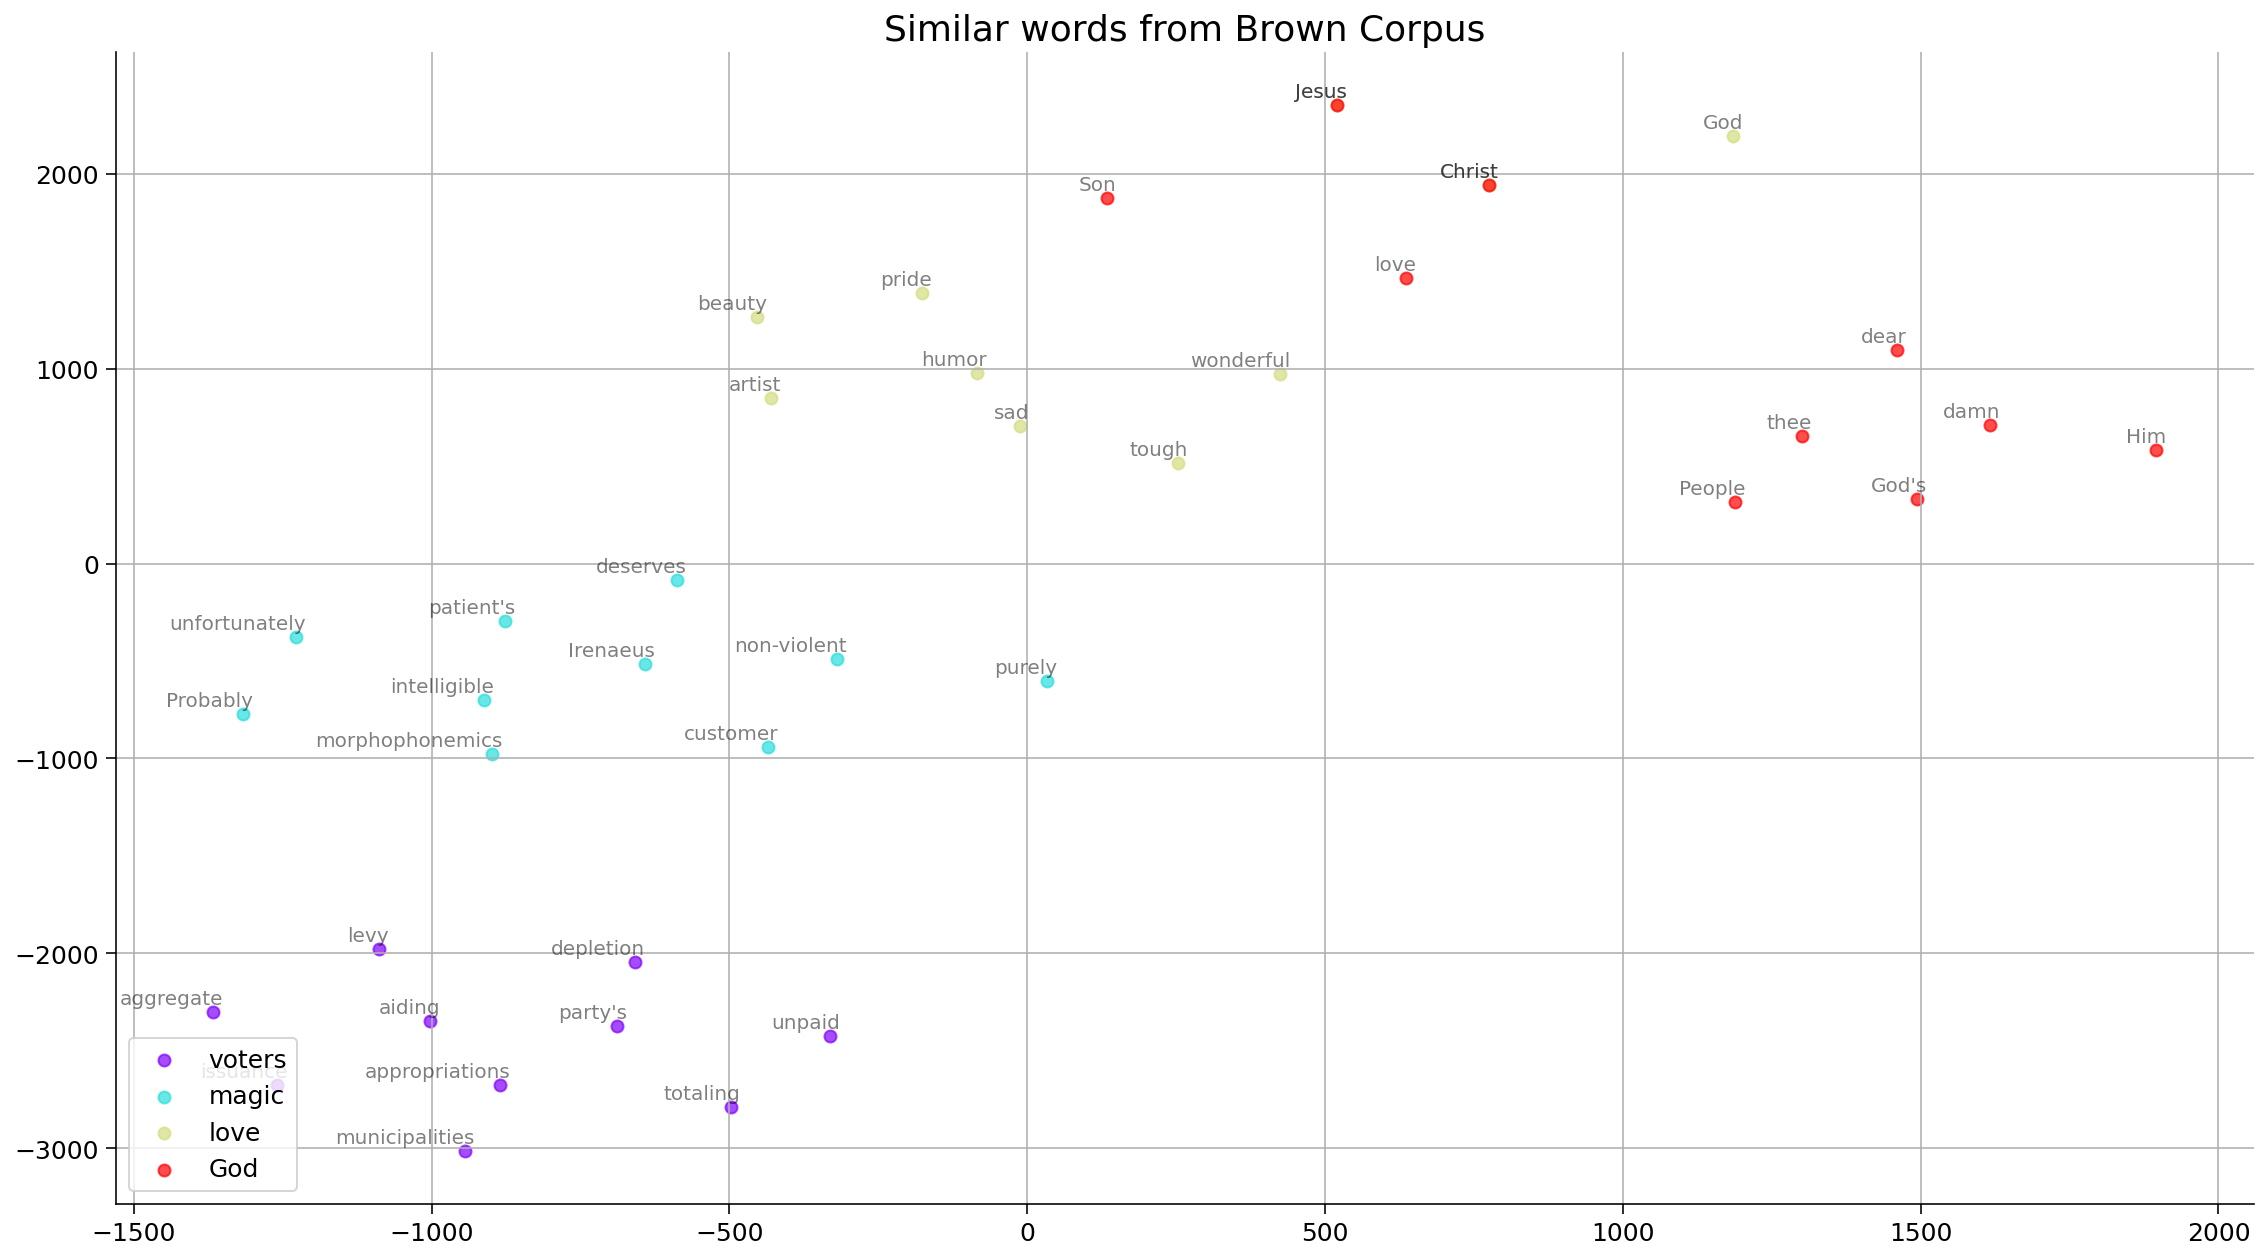

In [ ]:
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
tsne_plot_similar_words('Similar words from Brown Corpus', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

What does having higher similarity between two word embeddings mean?



Why are key clusters more spread than others?



# Section 2: Dataset

We will use the IMDB dataset from <insert link>, which consists of a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. We will use torchtext to download the dataset and prepare it for training, validation and testing. Our goal is to build a model that performs binary classification between positive and negative movie reviews.

We use `fix_length` argument to pad sentences of length less than `sentence_length` or truncate sentences of length greater than `sentence_length`. 

However, it's worth noting that we do not have to use `fix_length` to set all our sentences in each batch to the same length. If we use the `.pad` method of our `data.Field`, it will pad our sentences either to our `fix_length` parameter or to the longest sentence in the batch. Why might this be ill-advised? (Hint: think about what happens if we have a 4-token and a 90-token sentence in the same batch. Why might the padded 4-token sentence not be good to input into our model?)

<br><br><br>

A better way is using the `BucketIterator` along with `sort_key`. This will sort our batches into ones where all the sentences have similar lengths before padding to the greatest length sentence. This reduces the number of <pad> tokens we need to process which can make our model much more efficient! For a more detailed look at this process, refer to [this article.](https://https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a)

In [ ]:
batch_size = 32 

def load_dataset(sentence_length = 50):
    TEXT = data.Field(sequential=True, tokenize=nltk.word_tokenize, lower=True,
                      include_lengths=True, batch_first=True, fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

    # If no specific vector embeddings are specified,
    # Torchtext initializes random vector embeddings
    # which would get updated during training through backpropagation.
    TEXT.build_vocab(train_data)
    LABEL.build_vocab(train_data)

    train_data, valid_data = train_data.split(split_ratio=0.7, random_state = random.seed(seed))

   
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                   repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter

The cell below can take 15-30 secs to run.

In [ ]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset()

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:02<00:00, 41.7MB/s]


Let's see what the data looks like. The words in the reviews are tokenized using the NLTK `word_tokenize` function.  

In [ ]:
def text_from_dict(arr, dictionary):
  text = []
  for element in arr:
    text.append(dictionary[element])
  return text

for idx, batch in enumerate(train_iter):
    text = batch.text[0]
    target = batch.label

    for itr in range(25,30):
      # vocab.itos gives us our mapping of indices to tokens)
      print('Review: ', ' '.join(text_from_dict(text[itr], TEXT.vocab.itos)))
      print('Label: ', int(target[itr].item()), '\n')
   
    print('[0: Negative Review, 1: Positive Review]')
    if idx==0:
      break

Review:  remember the good ol ' animated batman show from the 90 's ? the one that people praised ? the one that people of all ages could all appreciate ? the one that showed batman as a real detective instead of the hulk in a bat suit ? the one
Label:  0 

Review:  went to wal-mart and found this film on dvd and had no idea whether i made a bad purchase or a good one . it is the later outcome to my viewing the entire film from beginning to end . michelle rodriquez , ( diana guzman ) , '' bloodrayne
Label:  1 

Review:  after repeated listenings to the cd soundtrack , i knew i wanted this film , got it for christmas and i was amazed . marc bolan had such charisma , i ca n't describe it . i 'd heard about him in that way , but did n't understand what
Label:  1 

Review:  this is one of the best films i have seen in years ! i am not a gwyneth paltrow fan , but she is excellent as emma woodhouse . alan cumming is superb as reverand elton , and emma thompson 's sister , sophie , is hysteri

In [ ]:
#@title Training
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
      #train
      model.train()
      running_loss = 0.
      correct, total = 0, 0 
      steps = 0

      for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        # print(type(text), text.shape)
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        # add micro for coding training loop
        optimizer.zero_grad()
        output = model(text)
 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        steps += 1
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
      train_loss.append(running_loss/len(train_iter))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(text)
    
            loss = criterion(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(valid_iter))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}%')
  
    return train_loss, train_acc, validation_loss, validation_acc

In [ ]:
#@title Testing
def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [ ]:
#@title Helper Functions
# helpers
def plot_train_val(x, train, val, train_label, val_label, title):
  with plt.xkcd():
    plt.plot(x, train, label=train_label)
    plt.plot(x, val, label=val_label)
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title(title)
    plt.show()

def count_parameters(model):
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return parameters

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

# Section 3: 1D CNN

Over the last few weeks, you were introduced to CNNs and used them to work on a range of interesting deep learning applications in vision. You also discussed where else these networks might be useful. Can we apply CNNs to language?

## Section 3.1: Working of 1D CNN

https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-cnn.html

## Section 3.2: Code


Now we will implement a 1D CNN. 

* Here we will use [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)  layer instead of pretrained word embeddings. This is a design choice. Using `nn.Embedding` layer in the network allows us to train word embeddings specific to the problem at hand. You are given the `vocab_size` which is the size of the dictionary of embeddings, and the `embed_size` which is the size of each embedding vector. 

* The 1D CNN should work for any number kernel size and corresponsing number of channels. Both `kernel_sizes` and `num_channels` are lists. Each element of these lists corresponds to the kernel size and output channels of a Conv1D layer.

* Use [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html) 

* Determine the size of inputs and outputs to the fully-connected layer using the reference example given above.  

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        # This for loop adds the Conv1D layers to your network
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        embeddings = embeddings.permute(0, 2, 1)
        # Concatenating the average-pooled outputs 
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        
        outputs = self.fc(encoding)
        return outputs

# Uncomment to test
sampleCNN = TextCNN(1000, 300, [1, 2, 3], [10, 20, 30])
print(sampleCNN)

TextCNN(
  (embedding): Embedding(1000, 300)
  (fc): Linear(in_features=60, out_features=2, bias=True)
  (pool): AdaptiveMaxPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(300, 10, kernel_size=(1,), stride=(1,))
    (1): Conv1d(300, 20, kernel_size=(2,), stride=(1,))
    (2): Conv1d(300, 30, kernel_size=(3,), stride=(1,))
  )
)


Epoch: 1,  Training Loss: 1.2858, Training Accuracy:  50.56%
Validation Loss: 0.7876, Validation Accuracy:  51.75%
Epoch: 2,  Training Loss: 0.7699, Training Accuracy:  52.31%
Validation Loss: 0.7682, Validation Accuracy:  52.45%
Epoch: 3,  Training Loss: 0.7443, Training Accuracy:  54.13%
Validation Loss: 0.7534, Validation Accuracy:  53.47%
Epoch: 4,  Training Loss: 0.7219, Training Accuracy:  55.91%
Validation Loss: 0.7416, Validation Accuracy:  54.47%
Epoch: 5,  Training Loss: 0.7022, Training Accuracy:  57.46%
Validation Loss: 0.7317, Validation Accuracy:  55.51%
Epoch: 6,  Training Loss: 0.6841, Training Accuracy:  59.19%
Validation Loss: 0.7233, Validation Accuracy:  55.89%
Epoch: 7,  Training Loss: 0.6676, Training Accuracy:  60.67%
Validation Loss: 0.7176, Validation Accuracy:  56.91%
Epoch: 8,  Training Loss: 0.6527, Training Accuracy:  61.98%
Validation Loss: 0.7093, Validation Accuracy:  56.89%
Epoch: 9,  Training Loss: 0.6384, Training Accuracy:  63.49%
Validation Loss: 0.

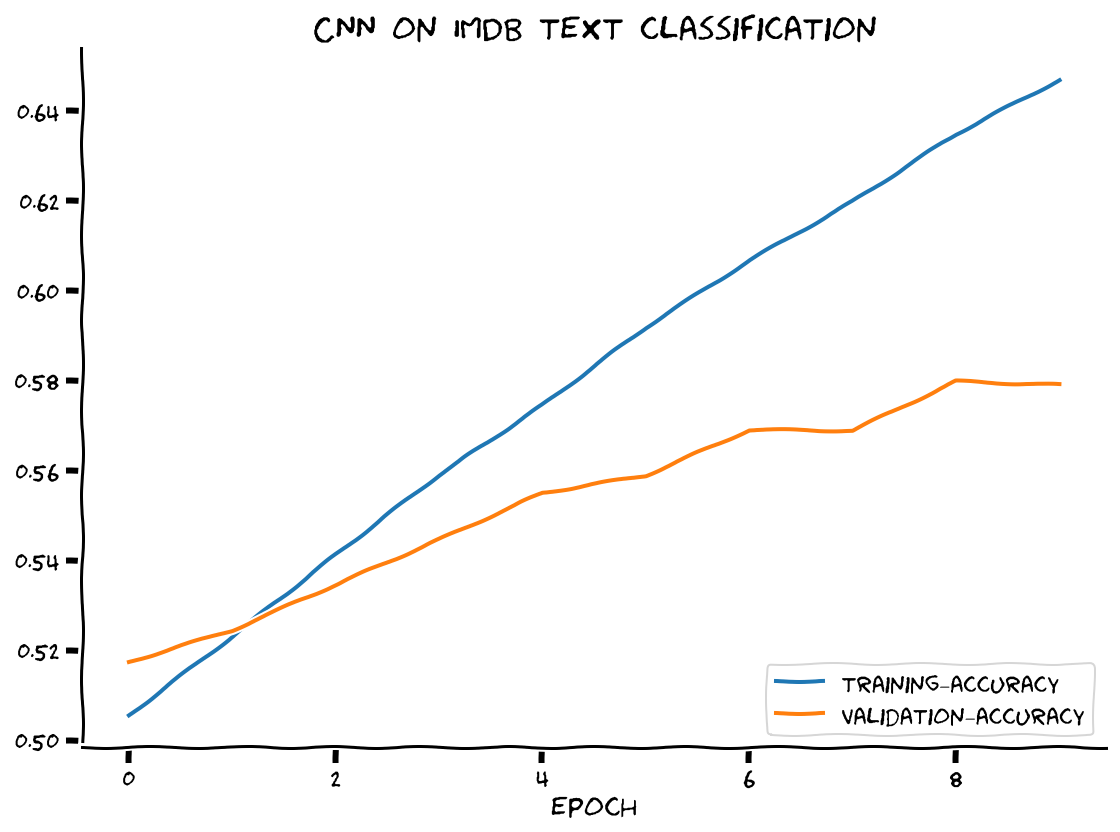



Number of parameters =  11563102


In [ ]:
# Model hyperparameters
learning_rate = 0.00001
embedding_length = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 100, 100]
epochs = 10

# Initialize model, training and testing
cnn_model = TextCNN(vocab_size, embedding_length, kernel_sizes, nums_channels)
cnn_model.to(device)
cnn_model.apply(init_weights)
cnn_start_time = time.time()
cnn_train_loss, cnn_train_acc, cnn_validation_loss, cnn_validation_acc = train(cnn_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - cnn_start_time))
test_accuracy = test(cnn_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

# Plot accuracies
plot_train_val(np.arange(0,epochs), cnn_train_acc, cnn_validation_acc, 'training_accuracy', 'validation_accuracy', 'CNN on IMDB text classification')

# Number of parameters in model
paramters = count_parameters(cnn_model)
print('\n\nNumber of parameters = ',  paramters)

---
# Section 4: RNN



Recurrent neural networks, or RNNs , are a family of neural networks for processing sequential data. Just as a convolutional network is specialized for processing a grid of values X such as an image, a recurrent neural network is specialized for processing a sequence of values. RNNs prove useful in many scenarios where other deep learning models are not effective.



## Section 4.1: Working of a RNN

* https://d2l.ai/chapter_recurrent-neural-networks/rnn.html
* https://d2l.ai/chapter_natural-language-processing-applications/sentiment-analysis-rnn.html

## Section 4.2: Code

Now we will write a Vanilla RNN using PyTorch.

* Once again we will use `nn.Embedding`. You are given the `vocab_size` which is the size of the dictionary of embeddings, and the `embed_size` which is the size of each embedding vector.  

* Add 2 [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) layers. This would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results.

* Determine the size of inputs and outputs to the fully-connected layer.


In [ ]:
class VanillaRNN(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(VanillaRNN, self).__init__()

    self.hidden_size = hidden_size
    
    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2)
    self.fc = nn.Linear(2*hidden_size, output_size)

  def forward(self, inputs):
    input = self.word_embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size).to(device)) 
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2) 
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)
    
    return logits

# Uncomment to test
sampleRNN = VanillaRNN(10, 50, 1000, 300)
print(sampleRNN)

VanillaRNN(
  (word_embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


Epoch: 1,  Training Loss: 0.6965, Training Accuracy:  51.17%
Validation Loss: 0.6944, Validation Accuracy:  51.88%
Epoch: 2,  Training Loss: 0.6846, Training Accuracy:  55.39%
Validation Loss: 0.6775, Validation Accuracy:  57.88%
Epoch: 3,  Training Loss: 0.6665, Training Accuracy:  59.18%
Validation Loss: 0.6867, Validation Accuracy:  60.44%
Epoch: 4,  Training Loss: 0.6387, Training Accuracy:  63.90%
Validation Loss: 0.6607, Validation Accuracy:  61.33%
Epoch: 5,  Training Loss: 0.6153, Training Accuracy:  66.62%
Validation Loss: 0.6432, Validation Accuracy:  64.95%
Epoch: 6,  Training Loss: 0.5933, Training Accuracy:  68.96%
Validation Loss: 0.6428, Validation Accuracy:  65.24%
Epoch: 7,  Training Loss: 0.5632, Training Accuracy:  71.67%
Validation Loss: 0.6448, Validation Accuracy:  66.04%
Epoch: 8,  Training Loss: 0.5353, Training Accuracy:  74.14%
Validation Loss: 0.6344, Validation Accuracy:  66.51%
Epoch: 9,  Training Loss: 0.5074, Training Accuracy:  76.23%
Validation Loss: 0.

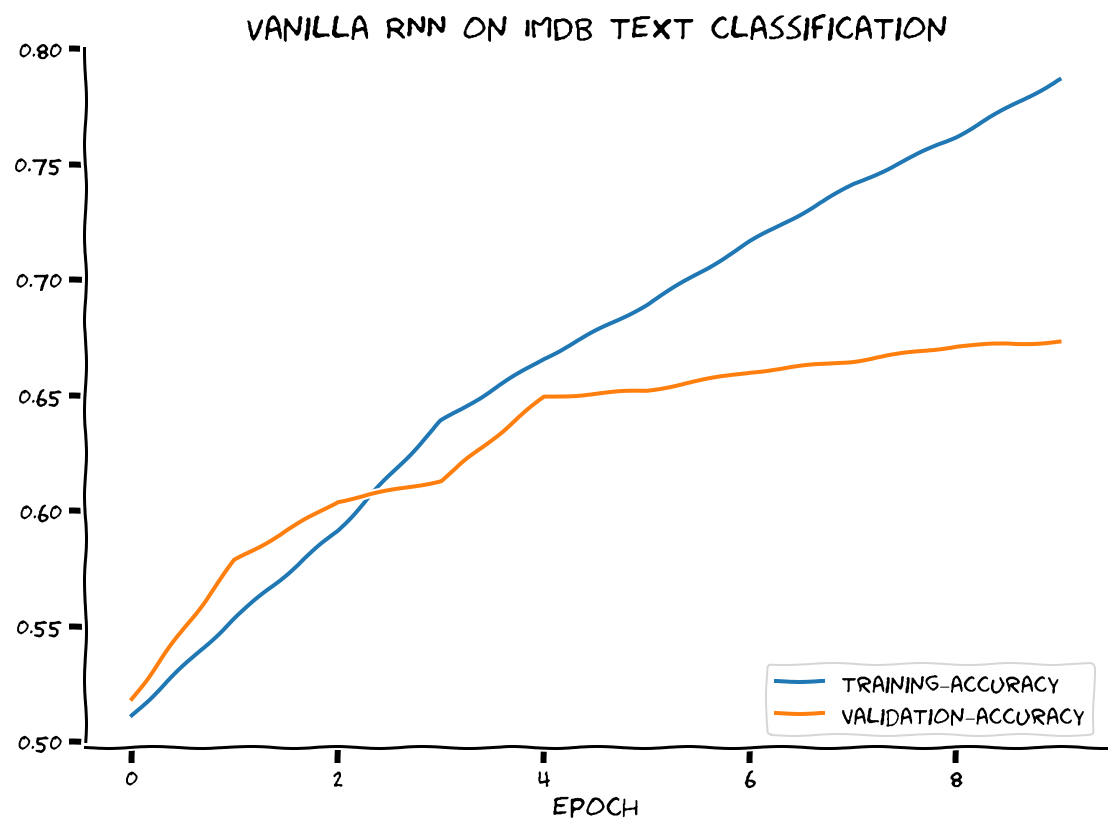



Number of parameters =  11483002


In [ ]:
# Model hyperparamters
learning_rate = 0.0002
output_size = 2
hidden_size = 100 
embedding_length = 100
epochs = 10

# Initialize model, training and testing
vanilla_rnn_model = VanillaRNN(output_size, hidden_size, vocab_size, embedding_length)
vanilla_rnn_model.to(device)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time))
test_accuracy = test(vanilla_rnn_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

# Plot accuracy curves
plot_train_val(np.arange(0,epochs), vanilla_train_acc, vanilla_validation_acc,
               'training_accuracy', 'validation_accuracy', 'Vanilla RNN on IMDB text classification')

# Number of model parameters
paramters = count_parameters(vanilla_rnn_model)
print('\n\nNumber of parameters = ',  paramters)

Based on exercises above would you say CNNs are faster than RNNs? Why?

# Section 5: LSTM

## Section 5.1: Working for a LSTM

https://d2l.ai/chapter_recurrent-modern/lstm.html

## Section 5.2: Code

In [ ]:
class LSTM(nn.Module):
  def __init__(self, layers, output_size, hidden_size, vocab_size, embed_size):
    super(LSTM, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.n_layers = layers

    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.dropout = nn.Dropout(0.5)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=self.n_layers)
    self.fc = nn.Linear(self.n_layers*self.hidden_size, output_size)

  def forward(self, input_sentences):
    input = self.word_embeddings(input_sentences).permute(1, 0, 2)
    hidden = (torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device),
            torch.randn(self.n_layers, input.shape[1], self.hidden_size).to(device))
    input = self.dropout(input)
    output, hidden = self.lstm(input, hidden)
    h_n = hidden[0].permute(1, 0, 2)
    h_n = h_n.contiguous().view(h_n.shape[0], -1)
    logits = self.fc(h_n)
    return logits

The cell below will take 1-2 minutes to run. 

Epoch: 1,  Training Loss: 0.6960, Training Accuracy:  50.22%
Validation Loss: 0.6938, Validation Accuracy:  49.88%
Epoch: 2,  Training Loss: 0.6933, Training Accuracy:  51.05%
Validation Loss: 0.6928, Validation Accuracy:  50.99%
Epoch: 3,  Training Loss: 0.6915, Training Accuracy:  52.42%
Validation Loss: 0.6919, Validation Accuracy:  52.20%
Epoch: 4,  Training Loss: 0.6902, Training Accuracy:  53.25%
Validation Loss: 0.6908, Validation Accuracy:  53.07%
Epoch: 5,  Training Loss: 0.6880, Training Accuracy:  54.14%
Validation Loss: 0.6757, Validation Accuracy:  57.39%
Epoch: 6,  Training Loss: 0.6720, Training Accuracy:  58.45%
Validation Loss: 0.6558, Validation Accuracy:  61.75%
Epoch: 7,  Training Loss: 0.6574, Training Accuracy:  61.18%
Validation Loss: 0.6447, Validation Accuracy:  63.65%
Epoch: 8,  Training Loss: 0.6500, Training Accuracy:  62.34%
Validation Loss: 0.6329, Validation Accuracy:  65.27%
Epoch: 9,  Training Loss: 0.6399, Training Accuracy:  63.87%
Validation Loss: 0.

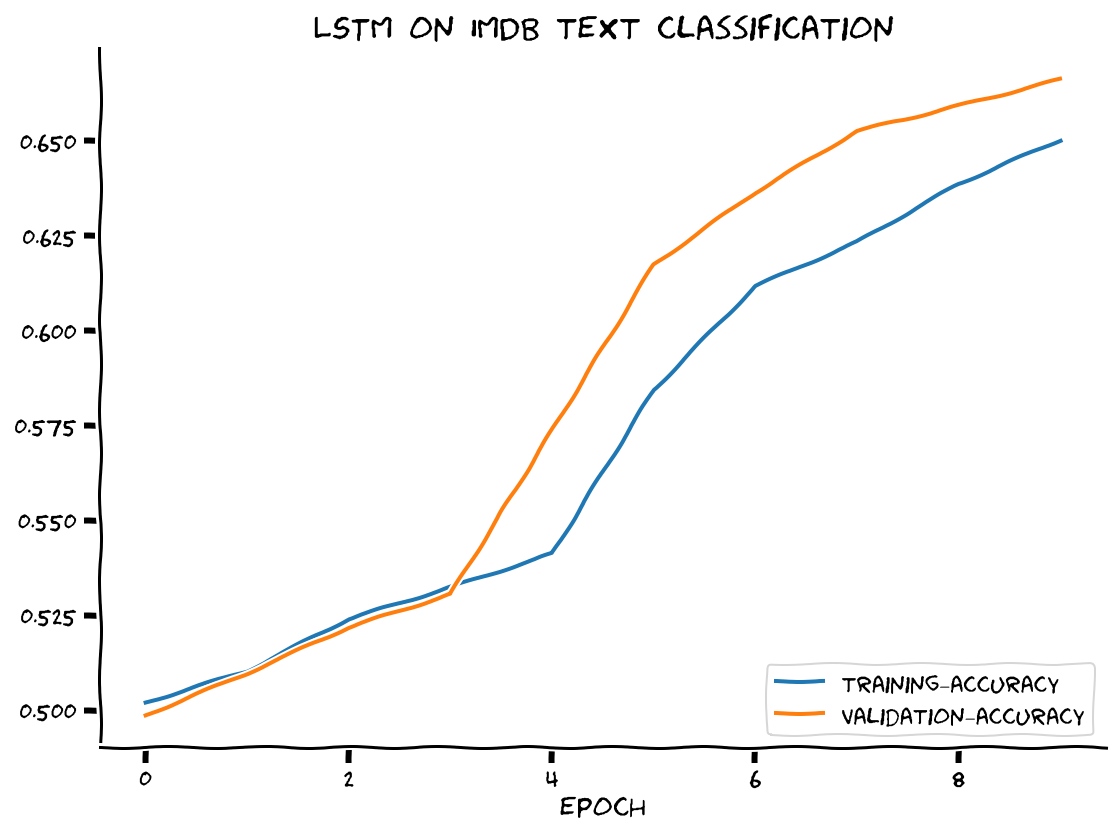

In [ ]:
# Hyperparameters
learning_rate = 0.0003
output_size = 2
hidden_size = 16
embedding_length = 100
epochs = 10
layers = 2

# Model, training, testing
lstm_model = LSTM(layers, output_size, hidden_size, vocab_size, embedding_length)
lstm_model.to(device)
lstm_train_loss, lstm_train_acc, lstm_validation_loss, lstm_validation_acc = train(lstm_model, device, train_iter, valid_iter, epochs, learning_rate)
test_accuracy = test(lstm_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%\n')

# Plotting accuracy curve
with plt.xkcd():
    plot_train_val(np.arange(0,epochs), lstm_train_acc, lstm_validation_acc,
                   'training_accuracy', 'validation_accuracy', 'LSTM on IMDB text classification')

# Reference

* https://d2l.ai/